In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset 
from torchvision.utils import make_grid

In [2]:
train = pd.read_csv('../data/train.csv')

x_train = (train.iloc[:, 1:].values).astype('float32')/255.0
y_train = train['label'].values

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, stratify=y_train, random_state=42, test_size=0.2)


In [3]:
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

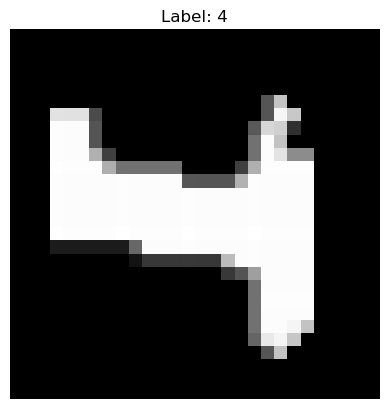

In [4]:
plt.imshow(x_train[3].reshape(28,28), cmap='gray')
plt.axis('off')
plt.title('Label: %d' % y_train[3])
plt.show()

In [5]:
train_tensor = TensorDataset(x_train, y_train)
test_tensor = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_tensor, batch_size=50, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=50, shuffle=False)

torch.Size([784])


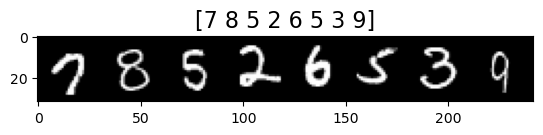

In [6]:
for batch_idx,(data,target) in enumerate(train_loader):
    img_grid = make_grid(data[0:8,].reshape(8,1,28,28),nrow=8)
    img_target_grid = target[0:8,].numpy()
    break
print(data[0].shape)
plt.imshow(img_grid.numpy().transpose((1,2,0)))
plt.rcParams['figure.figsize']=(10,2)
plt.title(img_target_grid,size=16)
plt.show()

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [8]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, layer_dim, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_size, hidden_size, layer_dim,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_size,device=x.device)
        out, hn = self.rnn(x,h0)
        out = self.fc(out[:, -1, :])
        return out

In [9]:
input_size = 28
seq_size = 28
hidden_size = 128
num_layers = 2
output_size = 10

model =  RNNModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()

lr = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [10]:
model

RNNModel(
  (rnn): RNN(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [25]:
def train_model(num_epoch):
    model.train()
    for batch_idx ,(data, target) in enumerate(train_loader):
        data = data.to(device)
        data = data.view(-1,seq_size,input_size)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx+1)*len(data), len(train_loader.dataset)
                ,loss.item()
            ))

def eval_model(data_loader):
    model.eval()
    loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            data = data.view(-1,seq_size,input_size)
            target = target.to(device)

            output = model(data)
            loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()

    loss /= len(data_loader.dataset)
    acc = 100. * correct / len(data_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)
    ))


In [26]:
num_epochs = 10


for n in range(num_epochs):
    train_model(n)
    eval_model(test_loader)

Train Epoch: 0 [50/33600]	Loss: 0.011854
Train Epoch: 0 [5050/33600]	Loss: 0.072128
Train Epoch: 0 [10050/33600]	Loss: 0.007192
Train Epoch: 0 [15050/33600]	Loss: 0.152281
Train Epoch: 0 [20050/33600]	Loss: 0.027442
Train Epoch: 0 [25050/33600]	Loss: 0.103724
Train Epoch: 0 [30050/33600]	Loss: 0.023375
Test set: Average loss: -9.9582, Accuracy: 8213/8400 (98%)

Train Epoch: 1 [50/33600]	Loss: 0.015840
Train Epoch: 1 [5050/33600]	Loss: 0.010601
Train Epoch: 1 [10050/33600]	Loss: 0.002021
Train Epoch: 1 [15050/33600]	Loss: 0.007505
Train Epoch: 1 [20050/33600]	Loss: 0.062821
Train Epoch: 1 [25050/33600]	Loss: 0.053517
Train Epoch: 1 [30050/33600]	Loss: 0.014697
Test set: Average loss: -9.9827, Accuracy: 8225/8400 (98%)

Train Epoch: 2 [50/33600]	Loss: 0.003235
Train Epoch: 2 [5050/33600]	Loss: 0.001896
Train Epoch: 2 [10050/33600]	Loss: 0.132419
Train Epoch: 2 [15050/33600]	Loss: 0.015476
Train Epoch: 2 [20050/33600]	Loss: 0.070830
Train Epoch: 2 [25050/33600]	Loss: 0.109053
Train Epoch: